In [1]:
import time
from dataclasses import dataclass
from dataclasses import field
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import os

print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/notebook
/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds


In [3]:
DAY_SECONDS = 60 * 60 * 24


def today() -> pd.Timestamp:
    """
    pd.Timestamp today midnight
    """
    seconds = time.time() - time.timezone
    seconds_round_day = seconds - (seconds % DAY_SECONDS)
    return pd.Timestamp.fromtimestamp(seconds_round_day + time.timezone)

Pick some bonds to use in the current optimization

In [4]:
BOND_UNIVERSE: tuple[str] = (
    "RU000A0GN9A7",
    "RU000A0JV4N8",
    "RU000A0JWDN6",
    "RU000A0JV4Q1",
    "RU000A0JVA10",
    "RU000A0JW0S4",
    "RU000A0JUMH3",
)

In [5]:
from functools import cached_property


class BondDataProvider:
    """Data provider for bonds and"""

    def __init__(self):
        """Read all pre-downloaded data."""
        df_price = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_price.csv", parse_dates=["date"])
        df_price["date"] = df_price["date"].dt.date
        df_price = df_price.set_index(["date", "isin"])
        self._price = df_price.sort_index(level="date")

        self._dur = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_duration.csv", parse_dates=["date"])
        self._dur["date"] = self._dur["date"].dt.date
        self._dur = self._dur.set_index(["date", "isin"]).sort_index(level="date")

        self._static = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_static.csv")
        self._rating = pd.read_csv(
            "/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rating.csv", parse_dates=["update_date"]
        )
        self._rating["update_date"] = self._rating["update_date"].dt.date
        self._rating["isin"] = self._rating["isincode"]

        self._volume = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_volume.csv")
        self._rgbitr = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_rgbitr.csv", parse_dates=["date"])

        self._yield = pd.read_csv("/Users/svetlanatelnova/university/portfolio_optimization/hse-course-work-bonds/data/bond_data_yield.csv", parse_dates=["date"])
        self._yield["date"] = pd.to_datetime(self._yield["date"].dt.date)
        self._yield = self._yield.sort_values("date")

    @property
    def price(self):
        """
        df with bond's historical prices
        columns: 'isin','date','spread','ask','bid','ai','last','mid'
        """
        return self._price

    @property
    def duration(self):
        """
        df with bond's precomputed duration data
        columns: 'id','date','isin','emission_id','emission_emitent_id','trading_ground_id','avar_price',
        'convexity','convexity_offer','dur','dur_to','dur_mod','dur_mod_to'
        """
        return self._dur

    @property
    def static(self):
        """Static bond info including coupon data."""
        return self._static

    @property
    def rating(self):
        """Bond ratings data."""
        return self._rating

    @property
    def volume(self):
        """Traded volume data.
        columns: 'volume' -- traded volume ,'volume_lots' -- number of traded lots
        """
        return self._volume

    @property
    def yield_(self):
        """Estimated bond yields."""
        return self._yield

    @cached_property
    def rgbitr(self):
        """RGBITR benchmark."""
        return self._rgbitr[self._rgbitr["secid"] == "RGBITR"]

    @cached_property
    def rucbitr(self):
        """RUCBITR benchmark.

        Note: halts after 05/31/2023
        """
        return self._rgbitr[self._rgbitr["secid"] == "RUCBITR"]


bond_data = BondDataProvider()

In [6]:
@dataclass
class BondPortfolio:
    """portfolio history and basic statistics."""

    bond_universe: tuple[str] = field(default=tuple)
    cash: float = 1

    def __post_init__(self):
        self.universe_size: int = len(self.bond_universe)

        # current portfolio portions of bonds from the universe
        self._weights: np.array = np.zeros(self.universe_size)

        # current quantities of bonds from the universe
        self._qty: np.array = np.zeros(self.universe_size)

        self._history_weights: dict[pd.Timestamp, np.array] = {}
        self._history_qty: dict[pd.Timestamp, np.array] = {}

        # current date
        self._date: pd.Timestamp = today()

    def update_portfolio(
        self, weights: np.array, qty: np.array, cash: float, date: pd.Timestamp
    ):
        """Should be called when bonds quantity is changed"""
        self._date = date
        self.cash = cash

        self._weights = weights
        self._history_weights[date] = weights

        self._qty = qty
        self._history_qty[date] = qty

    @property
    def weights(self):
        """Weights for the current_date."""
        return self._weights

    def wealth(self, prices: np.array):
        """Total value af assets and money on account."""
        return self.cash + self._qty @ prices

In [7]:
# create portfolio for a simple strategy
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

## Random Weights Strategy

In [8]:
%%time
start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
day_ = pd.Timedelta(days=1)

dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)
    a = (np.random.uniform(-1, 1, port.universe_size) + 1) / 2

    price_today = bond_data.price.loc[
        pd.IndexSlice[slice(date, date), port.bond_universe], :
    ]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid
    new_weights = a / a.sum(axis=0, keepdims=1)

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today
    print(new_weights)
    print(new_weights - port.weights)
    cash = wealth - qty @ price_today
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
[0.00227463 0.14563768 0.07510025 0.21924936 0.25554126 0.16635149
 0.13584533]
[0.00227463 0.14563768 0.07510025 0.21924936 0.25554126 0.16635149
 0.13584533]
2023-08-02
wealth = 0.9987444848461039
[0.196682   0.16736029 0.09378005 0.13477355 0.08654836 0.18050192
 0.14035383]
[ 0.19440737  0.02172261  0.01867981 -0.08447581 -0.16899289  0.01415042
  0.0045085 ]
2023-08-03
wealth = 0.9969183704305011
[0.17913005 0.20779906 0.06421521 0.14412142 0.13221187 0.15017636
 0.12234603]
[-0.01755194  0.04043876 -0.02956484  0.00934788  0.04566351 -0.03032556
 -0.0180078 ]
2023-08-04
wealth = 0.9961723427644408
[0.19685698 0.05381254 0.028799   0.14751075 0.03498769 0.30913597
 0.22889708]
[ 0.01772693 -0.15398651 -0.03541622  0.00338932 -0.09722418  0.15895961
  0.10655105]
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9940762356651702
[0.25137326 0.17572389 0.08096684 0.19256097 0.00794922 0.17373544
 0.11769038]
[ 0.05451628  0.12191135  0.05216785  0.04505023 -0.02703

wealth = 0.9708816392297882
[0.21047199 0.19868466 0.00373809 0.16122753 0.18819067 0.1697031
 0.06798397]
[ 0.01656845  0.11944808 -0.03699211 -0.03951841  0.0392122  -0.05603632
 -0.04268189]
2023-09-16
2023-09-17
2023-09-18
wealth = 0.9726640986491775
[0.0494035  0.32481257 0.16751396 0.33231256 0.05062317 0.07037894
 0.00495531]
[-0.16106848  0.12612791  0.16377587  0.17108503 -0.1375675  -0.09932416
 -0.06302866]
2023-09-19
wealth = 0.9697356685397812
[0.19642807 0.20798048 0.0781657  0.08216293 0.11443943 0.14402295
 0.17680044]
[ 0.14702456 -0.11683209 -0.08934825 -0.25014963  0.06381626  0.07364401
  0.17184513]
2023-09-20
wealth = 0.9703580141719487
[0.16905905 0.05650065 0.08245103 0.34429201 0.04652419 0.03456389
 0.26660918]
[-0.02736902 -0.15147983  0.00428533  0.26212908 -0.06791524 -0.10945906
  0.08980874]
CPU times: user 405 ms, sys: 31.7 ms, total: 437 ms
Wall time: 466 ms


### Random Weights Strategy Results

In [9]:
wealth

0.9703580141719487

In [10]:
# df with "dur_mod", "yield", "shape" field for each day and each bond
sharpe_data = (
    bond_data.duration.groupby(["date", "isin"])
    .dur_mod.mean()
    .to_frame()
    .loc[(slice(None), BOND_UNIVERSE), ["dur_mod"]]
    .fillna(float("inf"))
    .join(
        bond_data.yield_.set_index(["date", "isin"]).loc[
            (slice(None), BOND_UNIVERSE), ["yield"]
        ],
    )
)

sharpe_data["sharpe"] = sharpe_data["yield"] / sharpe_data["dur_mod"]
sharpe_data = sharpe_data.sort_index()

In [11]:
sharpe_data_sorted = sharpe_data.loc[date].sort_values(
    "sharpe", ascending=False
)
sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
sharpe_data_sorted["weight"] = (
    sharpe_data_sorted["sharpe_squared"]
    / sharpe_data_sorted["sharpe_squared"].sum()
)
sharpe_data_sorted
# select max sharp
# weights = (
#     sharpe_data_sorted.loc[(slice(None), universe), :]

,dur_mod,yield,sharpe,sharpe_squared,weight
isin,,,,,
RU000A0JUMH3,0.588109,0.115846,0.196981,0.038802,0.651056
RU000A0JVA10,1.177732,0.132693,0.112669,0.012694,0.212997
RU000A0JW0S4,1.855754,0.127511,0.068711,0.004721,0.079218
RU000A0JWDN6,2.274082,0.118546,0.052129,0.002717,0.045596
RU000A0GN9A7,6.657464,0.115169,0.017299,0.000299,0.005021
RU000A0JV4N8,5.636553,0.081891,0.014529,0.000211,0.003542
RU000A0JV4Q1,6.702876,0.082937,0.012373,0.000153,0.002569


In [12]:
sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )

dur_mod     yield    sharpe
date       isin                                      
2023-09-20 RU000A0JUMH3  0.588109  0.115846  0.196981
           RU000A0JVA10  1.177732  0.132693  0.112669
           RU000A0JW0S4  1.855754  0.127511  0.068711
           RU000A0JWDN6  2.274082  0.118546  0.052129
           RU000A0GN9A7  6.657464  0.115169  0.017299
           RU000A0JV4N8  5.636553  0.081891  0.014529
           RU000A0JV4Q1  6.702876  0.082937  0.012373

In [13]:
port = BondPortfolio(
    cash=1,
    bond_universe=BOND_UNIVERSE,
)

In [14]:
def get_weights(date: datetime.date, universe: tuple[str]):
    """Get target weights based on sharpe ratio."""
    sharpe_data_sorted = sharpe_data.loc[(date, slice(None)), :].sort_values(
        "sharpe", ascending=False
    )
    sharpe_data_sorted["sharpe_squared"] = sharpe_data_sorted["sharpe"] ** 2
    sharpe_data_sorted["weight"] = (
        sharpe_data_sorted["sharpe_squared"]
        / sharpe_data_sorted["sharpe_squared"].sum()
    )

    # select max sharp
    weights = (
        sharpe_data_sorted.loc[(slice(None), universe), :]
        .reset_index()["weight"]
        .fillna(0)
        .values
    )
    assert len(weights) == len(universe), f"{len(weights)},  {len(universe)}"
    return weights

In [15]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    new_weights = get_weights(date, BOND_UNIVERSE)  # optimal sharp weights

    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = -2.220446049250313e-16
2023-08-02
wealth = 0.9998776059973081
cash = 0.0
2023-08-03
wealth = 0.9978527371131432
cash = 2.220446049250313e-16
2023-08-04
wealth = 0.9979638505969906
cash = 1.1102230246251565e-16
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9964516162626472
cash = 1.1102230246251565e-16
2023-08-08
wealth = 0.9968897272080549
cash = 4.440892098500626e-16
2023-08-09
wealth = 0.995203588400843
cash = -1.1102230246251565e-16
2023-08-10
wealth = 0.9989990726492805
cash = 1.1102230246251565e-16
2023-08-11
wealth = 0.9959058195303009
cash = 1.1102230246251565e-16
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9964227757856775
cash = -1.1102230246251565e-16
2023-08-15
wealth = 0.9859243737486094
cash = 0.0
2023-08-16
wealth = 0.9928902742058034
cash = -1.1102230246251565e-16
2023-08-17
wealth = 0.9896478701483993
cash = 0.0
2023-08-18
wealth = 0.9898619585040243
cash = -1.1102230246251565e-16
2023-08-19
2023-08-20
2023-08-21
wealth = 0.994536924325512
c

### Sharpe Ratio Strategy Results

In [16]:
wealth

0.9804940314777225

## Quadratic optimization

In [17]:
# create portfolio for a quadratic optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [18]:
%%time

from baseline.quadratic import get_optimal_weights

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    rating_reduced = bond_data.rating[
        bond_data.rating["isin"].isin(port.bond_universe)
        & (bond_data.rating.update_date < date)
    ].sort_values("update_date")

    rating_reduced = rating_reduced.groupby("isin").num_rating.last()

    today_info = today_info.join(rating_reduced)
    today_info["num_rating"] = today_info["num_rating"].fillna(0)
    #
    # make predictions
    #
    new_weights = get_optimal_weights(
        bond_data=today_info,
        upper_bound=0.5,
        value_date=date,
        maturity_limit=10,
    )  # optimal sharp weights
    
    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = -1.1679546219056647e-13
2023-08-02
wealth = 1.0000037860816073
cash = -1.1679546219056647e-13
2023-08-03
wealth = 0.9963256745003232
cash = -1.162403506782539e-13
2023-08-04
wealth = 0.9895599962191838
cash = -1.1535217225855376e-13
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9874742394798312
cash = -1.1535217225855376e-13
2023-08-08
wealth = 0.9862315512629515
cash = -1.1513012765362873e-13
2023-08-09
wealth = 0.9874975561348939
cash = -1.1535217225855376e-13
2023-08-10
wealth = 0.987444831280657
cash = -1.1524114995609125e-13
2023-08-11
wealth = 0.9840048967607711
cash = -1.1479706074624119e-13
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9827308172475412
cash = -1.1468603844377867e-13
2023-08-15
wealth = 0.9801812696506077
cash = -1.142419492339286e-13
2023-08-16
wealth = 0.9812553297810452
cash = -1.1446399383885364e-13
2023-08-17
wealth = 0.9802001877791645
cash = -1.1446399383885364e-13
2023-08-18
wealth = 0.9826006952209113
cash = -1.146860384437786

In [19]:
wealth

0.9636249657462882

# Linear programming

In [20]:
from models.linear_programming import linear_minimize

In [21]:
# create portfolio for a linear programming optimization
port = BondPortfolio(
    bond_universe=BOND_UNIVERSE,
    cash=1,
)

In [22]:
%%time

start_date, end_date = (
    pd.Timestamp("2023-08-01"),
    bond_data.price.index.get_level_values(0).max(),
)
dates = pd.date_range(start_date, end_date).date
for date in dates:
    print("======================================================")
    print(date)

    if not date in bond_data.price.index.get_level_values('date'):
        continue

    price_today = bond_data.price.loc[slice(date, date), port.bond_universe, :]
    if price_today.empty:
        continue
    price_today = price_today.loc[(slice(None), port.bond_universe),].mid

    #
    # prepare data
    #
    today_info = (
        price_today.to_frame()
        .join(
            bond_data.duration.loc[
                pd.IndexSlice[slice(date, date), port.bond_universe], "dur_mod"
            ]
            .groupby(["date", "isin"])
            .mean()
            .fillna(float("inf"))
        )
        .join(
            bond_data.yield_.set_index(["date", "isin"]).loc[
                (slice(date, date), port.bond_universe), :
            ]
        )
    )

    new_weights=linear_minimize(today_info)
   
    wealth = port.wealth(price_today.values)
    print(f"{wealth = }")
    qty = wealth * new_weights / price_today.values
    cash = wealth - qty @ price_today.values
    print(f"{cash = }")
    port.update_portfolio(new_weights, qty, cash, date)

2023-08-01
wealth = 1.0
cash = 0.0
2023-08-02
wealth = 0.9978045374065733
cash = 0.0
2023-08-03
wealth = 0.9978455024310348
cash = 0.0
2023-08-04
wealth = 0.9980826679418175
cash = 0.0
2023-08-05
2023-08-06
2023-08-07
wealth = 0.9990478288376666
cash = 0.0
2023-08-08
wealth = 0.9990478288376666
cash = 0.0
2023-08-09
wealth = 0.998448400140364
cash = -1.1102230246251565e-16
2023-08-10
wealth = 0.9984486087790215
cash = 0.0
2023-08-11
wealth = 0.9990371641528787
cash = 0.0
2023-08-12
2023-08-13
2023-08-14
wealth = 0.9982379344215564
cash = 0.0
2023-08-15
wealth = 0.9972444325167902
cash = 0.0
2023-08-16
wealth = 0.9971169341858521
cash = 0.0
2023-08-17
wealth = 0.9972667362475559
cash = 1.1102230246251565e-16
2023-08-18
wealth = 0.998640777888944
cash = 0.0
2023-08-19
2023-08-20
2023-08-21
wealth = 0.9966549385588375
cash = 1.1102230246251565e-16
2023-08-22
wealth = 0.9974507246439919
cash = 0.0
2023-08-23
wealth = 0.9975320252235365
cash = 0.0
2023-08-24
wealth = 0.9975158275873549
cash

In [23]:
wealth

0.9968527743266545

In [24]:
def get_portfolio_value_history(portfolio: BondPortfolio):
    """
    df with 'qty', 'spread', 'ask', 'bid', 'ai', 'last', 'mid' columns for each bond and trading day of the `portfolio`
    """
    portfolio_df = pd.DataFrame.from_dict(
        portfolio._history_qty, orient="index", columns=portfolio.bond_universe
    )
    portfolio_df.index.name = "date"

    # wide df -> long df
    portfolio_df = pd.melt(
        portfolio_df.reset_index(),
        "date",
        value_vars=portfolio.bond_universe,
        var_name="isin",
        value_name="qty",
    ).set_index(["date", "isin"])

    price_df = bond_data.price.reset_index()
    price_df = price_df.set_index(["date", "isin"])

    portfolio_history = pd.merge(
        portfolio_df,
        price_df,
        how="left",
        left_index=True,
        right_index=True,
    )

    return portfolio_history

#### portfolio PNL

In [25]:
portfolio_summary = get_portfolio_value_history(port)
portfolio_summary["value"] = portfolio_summary["qty"] * portfolio_summary["mid"]
portfolio_summary_grouped = portfolio_summary.groupby("date")

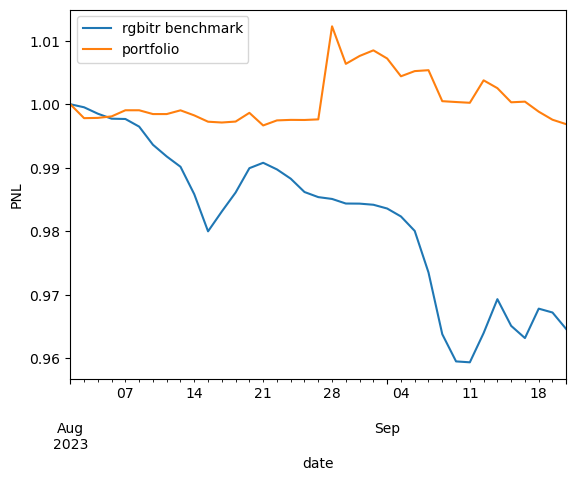

In [26]:
# benchmark rgbitr
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]
pnl_benchmark = np.cumprod(rgbitr_slice.close.pct_change().fillna(0) + 1)
pnl_benchmark.index = pd.DatetimeIndex(pnl_benchmark.index)
pnl_benchmark.plot(label="rgbitr benchmark")

# portfolio
pnl_portfolio = portfolio_summary_grouped.value.sum()
pnl_portfolio.index = pd.DatetimeIndex(pnl_portfolio.index)
pnl_portfolio.plot(label="portfolio")

plt.legend()
plt.ylabel("PNL");

### mean and median return

In [27]:
returns = portfolio_summary_grouped.value.sum().pct_change()
f"Mean return = {returns.mean():.3f}, Median return = {returns.median():.3f}"

'Mean return = -0.000, Median return = -0.000'

## Sharpe Ratio

In [28]:
rgbitr_slice = bond_data.rgbitr.set_index("date").loc[start_date:end_date]

returns_benchmark = rgbitr_slice.close.pct_change().iloc[1:]
returns_port = portfolio_summary_grouped.value.sum().pct_change().iloc[1:]

In [29]:
def get_sharp_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/s/sharperatio.asp
    """
    delta = returns.product() - returns_market.product()
    return delta / (returns - returns_market).std()


get_sharp_ratio(returns=returns_benchmark, returns_market=returns_port)

-1.0773223298474805e-101

### Information Ratio

In [30]:
def get_information_ratio(returns, returns_market):
    """
    Notes: https://www.investopedia.com/terms/i/informationratio.asp
    """
    difference_benchmark_portfolio = returns - returns_market
    tracking_error = difference_benchmark_portfolio.std()
    information_ratio = (returns.mean() - returns_market.mean()) / tracking_error
    return information_ratio

In [31]:
information_ratio = get_information_ratio(
    returns=returns_benchmark, returns_market=returns_port
)
information_ratio

-0.23427276810912845

## Returns

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


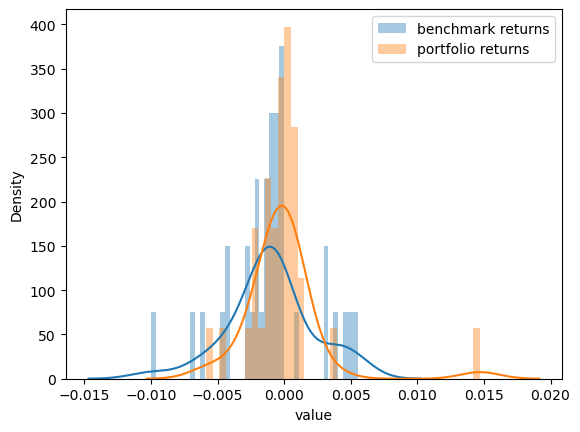

In [32]:
plt.figure()
sns.distplot(returns_benchmark, bins=42, label="benchmark returns")
sns.distplot(returns_port, bins=42, label="portfolio returns")
plt.legend();

# Returns difference

/Users/svetlanatelnova/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


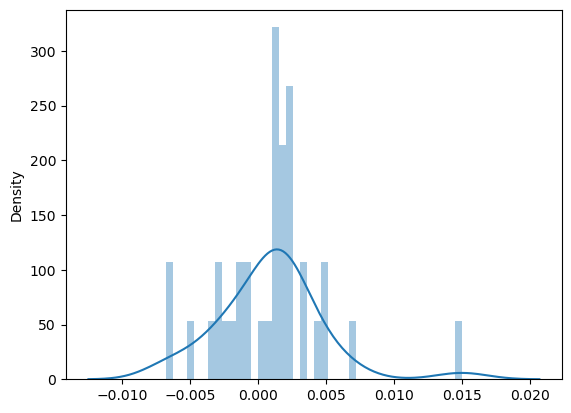

In [33]:
returns_diff = returns_port - returns_benchmark
sns.distplot(returns_diff, bins=42, label="portfolio returns");

In [34]:
from scipy import stats

stats.ttest_1samp(returns_diff, popmean=0)

Ttest_1sampResult(statistic=1.405636608654771, pvalue=0.16864742866414037)

# Benchmark Timing

One financially based refinement to the regression model is a benchmark timing component. The expanded model is

$$r_{P}(t) = \alpha_{P}+\beta_{P} * r_{B}(t) + \gamma_{P} * max(0, r_{B}(t)) + \epsilon_{P}(t)$$

We include the variable γP to determine whether the manager has any benchmark timing skill. The model includes a "down-market" beta, βP, and an "up-market" beta, βP + γP. If γP is significantly positive, then we say that there is evidence of timing skill; benchmark exposure is significantly different in up and down cases.


In [35]:
import statsmodels.api as sm
import numpy as np

timing_df = returns_benchmark.to_frame().rename(columns={'close':'beta'})
timing_df['gamma'] = timing_df['beta']
timing_df.loc[timing_df['beta'] < 0, 'gamma'] = 0

X = sm.add_constant(timing_df)
benchmark_timing_model = sm.OLS(returns_port,X)
results = benchmark_timing_model.fit()
results.params

const    0.000700
beta     0.409010
gamma   -0.516037
dtype: float64

## Value at Risk

In [36]:
alpha = 0.05
returns_benchmark.quantile(alpha)

-0.006116591003621885

## Skewness of Returns

In [37]:
alpha = 0.05
returns_benchmark.skew()

-0.20963976217357644